In [38]:
import pandas as pd 
ruleBasedParsing = pd.read_csv("VLM_responses_Baseline_SemanticParser.csv")
ruleBasedParsing.head()

,UserPrompt,AssistantResponse,JSON,Accurate,SemanticParser
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,"{'task': 'view traffic updates', 'interactions..."
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,{'task': 'change the contact name to Jane Do u...
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,"{'task': 'give their answer verbally', 'intera..."
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions..."
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,"{'task': 'save the user', 'interactions': ['Sa..."


In [39]:
seq2seqParsing = pd.read_csv("Seq2SeqParsingOutput.csv")
seq2seqParsing.head()

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,Convert this into the corresponding UI JSON: [...
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,Convert this into the corresponding UI JSON: [...
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,Convert this into the corresponding UI JSON: []}
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions..."
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,Convert this into the corresponding UI JSON: [...


In [40]:
seq2seqParsing["RuleBasedParsing"] = ruleBasedParsing["SemanticParser"]
seq2seqParsing.head()

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser,RuleBasedParsing
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,Convert this into the corresponding UI JSON: [...,"{'task': 'view traffic updates', 'interactions..."
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,Convert this into the corresponding UI JSON: [...,{'task': 'change the contact name to Jane Do u...
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,Convert this into the corresponding UI JSON: []},"{'task': 'give their answer verbally', 'intera..."
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions...","{'task': 'complete the task of', 'interactions..."
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,Convert this into the corresponding UI JSON: [...,"{'task': 'save the user', 'interactions': ['Sa..."


In [42]:
from difflib import SequenceMatcher

def string_similarity(a, b):
    return SequenceMatcher(None, str(a), str(b)).ratio()

def jaccard_similarity(list1, list2):
    set1, set2 = set(list1 or []), set(list2 or [])
    if not set1 and not set2:
        return 1.0
    return len(set1 & set2) / len(set1 | set2)


In [43]:
def evaluate_parser(df, parser_col, fields=["task", "buttons", "fields"]):
    scores = {field: [] for field in fields}
    exact_match_count = 0

    for _, row in df.iterrows():
        pred = row[parser_col]
        true = row["JSON"]

        all_match = True
        for field in fields:
            pred_val = pred.get(field, "")
            true_val = true.get(field, "")

            if isinstance(true_val, list):
                sim = jaccard_similarity(pred_val, true_val)
            else:
                sim = string_similarity(pred_val, true_val)

            scores[field].append(sim)

            if sim < 1.0:
                all_match = False

        if all_match:
            exact_match_count += 1

    avg_scores = {f"avg_{field}_similarity": sum(scores[field]) / len(scores[field]) for field in fields}
    avg_scores["exact_match_rate"] = exact_match_count / len(df)
    return avg_scores


In [44]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ast

# Assuming df is your DataFrame
# If JSON and Seq2SeqParser are dictionaries (or strings of dicts), convert them to string
def preprocess_cell(cell):
    if isinstance(cell, dict):
        return str(cell)
    try:
        # Try parsing if it's a string version of a dict
        return str(ast.literal_eval(cell))
    except:
        return str(cell)

seq2seqParsing['JSON_str'] = seq2seqParsing['JSON'].apply(preprocess_cell)
seq2seqParsing['Seq2Seq_str'] = seq2seqParsing['Seq2SeqParser'].apply(preprocess_cell)

# Compute cosine similarity using TF-IDF
vectorizer = TfidfVectorizer()
all_texts = seq2seqParsing['JSON_str'].tolist() + seq2seqParsing['Seq2Seq_str'].tolist()
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Split back into two matrices
json_tfidf = tfidf_matrix[:len(seq2seqParsing)]
seq2seq_tfidf = tfidf_matrix[len(seq2seqParsing):]

# Compute pairwise cosine similarity
similarities = cosine_similarity(json_tfidf, seq2seq_tfidf)

# Diagonal gives the similarity of each pair (JSON vs Seq2Seq in same row)
seq2seqParsing['JSON_Seq2Seq_Similarity'] = [similarities[i, i] for i in range(len(seq2seqParsing))]

# Display results
print(seq2seqParsing[['JSON', 'Seq2SeqParser', 'JSON_Seq2Seq_Similarity']])

seq2seqParsing.head()


                                                 JSON  \
0   {\n   "task":"view traffic updates",\n   "inte...   
1   {\n   "task":"change contact name to Jane Do",...   
2   {\n   "task":"answer verbally and submit",\n  ...   
3   {\n   "task":"maintain current weight",\n   "i...   
4   {\n   "task":"save location",\n   "interaction...   
5   {\n   "task":"view image 3 in a larger view",\...   
6   {\n   "task":"note about my mood",\n   "intera...   
7   {\n   "task":"see Giovani's stats",\n   "inter...   
8   {\n   "task":"unsave this location",\n   "inte...   
9   {\n   "task":"search for Medical Tales Retold"...   
10  {\n   "task":"exit out of the sign up menu",\n...   
11  {\n   "task":"watch the stream",\n   "interact...   
12  {\n   "task":"write a review",\n   "interactio...   
13  {\n   "task":"view my statistics",\n   "intera...   
14  {\n   "task":"see all the trending campaigns",...   
15  {\n   "task":"add a new VPN",\n   "interaction...   
16  {\n   "task":"go back to th

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser,RuleBasedParsing,JSON_str,Seq2Seq_str,JSON_Seq2Seq_Similarity
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,Convert this into the corresponding UI JSON: [...,"{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...",Convert this into the corresponding UI JSON: [...,0.646972
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,Convert this into the corresponding UI JSON: [...,{'task': 'change the contact name to Jane Do u...,"{'task': 'change contact name to Jane Do', 'in...",Convert this into the corresponding UI JSON: [...,0.120010
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,Convert this into the corresponding UI JSON: []},"{'task': 'give their answer verbally', 'intera...","{'task': 'answer verbally and submit', 'intera...",Convert this into the corresponding UI JSON: []},0.000000
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions...","{'task': 'complete the task of', 'interactions...","{'task': 'maintain current weight', 'interacti...","{'task': 'complete the task of', 'interactions...",0.714821
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,Convert this into the corresponding UI JSON: [...,"{'task': 'save the user', 'interactions': ['Sa...","{'task': 'save location', 'interactions': ['Fi...",Convert this into the corresponding UI JSON: [...,0.822550


In [45]:
seq2seqParsing['RuleBasedParsing_str'] = seq2seqParsing['RuleBasedParsing'].apply(preprocess_cell)

# Compute cosine similarity using TF-IDF
vectorizer = TfidfVectorizer()
all_texts = seq2seqParsing['JSON_str'].tolist() + seq2seqParsing['RuleBasedParsing_str'].tolist()
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Split back into two matrices
json_tfidf = tfidf_matrix[:len(seq2seqParsing)]
seq2seq_tfidf = tfidf_matrix[len(seq2seqParsing):]

# Compute pairwise cosine similarity
similarities = cosine_similarity(json_tfidf, seq2seq_tfidf)

# Diagonal gives the similarity of each pair (JSON vs Seq2Seq in same row)
seq2seqParsing['JSON_RuleBased_Similarity'] = [similarities[i, i] for i in range(len(seq2seqParsing))]

# Display results
print(seq2seqParsing[['JSON', 'Seq2SeqParser', 'JSON_RuleBased_Similarity']])

seq2seqParsing.head()

                                                 JSON  \
0   {\n   "task":"view traffic updates",\n   "inte...   
1   {\n   "task":"change contact name to Jane Do",...   
2   {\n   "task":"answer verbally and submit",\n  ...   
3   {\n   "task":"maintain current weight",\n   "i...   
4   {\n   "task":"save location",\n   "interaction...   
5   {\n   "task":"view image 3 in a larger view",\...   
6   {\n   "task":"note about my mood",\n   "intera...   
7   {\n   "task":"see Giovani's stats",\n   "inter...   
8   {\n   "task":"unsave this location",\n   "inte...   
9   {\n   "task":"search for Medical Tales Retold"...   
10  {\n   "task":"exit out of the sign up menu",\n...   
11  {\n   "task":"watch the stream",\n   "interact...   
12  {\n   "task":"write a review",\n   "interactio...   
13  {\n   "task":"view my statistics",\n   "intera...   
14  {\n   "task":"see all the trending campaigns",...   
15  {\n   "task":"add a new VPN",\n   "interaction...   
16  {\n   "task":"go back to th

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser,RuleBasedParsing,JSON_str,Seq2Seq_str,JSON_Seq2Seq_Similarity,RuleBasedParsing_str,JSON_RuleBased_Similarity
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,Convert this into the corresponding UI JSON: [...,"{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...",Convert this into the corresponding UI JSON: [...,0.646972,"{'task': 'view traffic updates', 'interactions...",1.000000
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,Convert this into the corresponding UI JSON: [...,{'task': 'change the contact name to Jane Do u...,"{'task': 'change contact name to Jane Do', 'in...",Convert this into the corresponding UI JSON: [...,0.120010,{'task': 'change the contact name to Jane Do u...,0.792990
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,Convert this into the corresponding UI JSON: []},"{'task': 'give their answer verbally', 'intera...","{'task': 'answer verbally and submit', 'intera...",Convert this into the corresponding UI JSON: []},0.000000,"{'task': 'give their answer verbally', 'intera...",0.736367
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions...","{'task': 'complete the task of', 'interactions...","{'task': 'maintain current weight', 'interacti...","{'task': 'complete the task of', 'interactions...",0.714821,"{'task': 'complete the task of', 'interactions...",0.813483
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,Convert this into the corresponding UI JSON: [...,"{'task': 'save the user', 'interactions': ['Sa...","{'task': 'save location', 'interactions': ['Fi...",Convert this into the corresponding UI JSON: [...,0.822550,"{'task': 'save the user', 'interactions': ['Sa...",0.892062


In [34]:
%pip install sentence-transformers


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [46]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import ast

# Load a BERT model optimized for sentence similarity
model = SentenceTransformer('all-MiniLM-L6-v2')

In [47]:
# Generate embeddings
json_embeddings = model.encode(seq2seqParsing['JSON_str'].tolist(), convert_to_tensor=True)
seq2seq_embeddings = model.encode(seq2seqParsing['Seq2Seq_str'].tolist(), convert_to_tensor=True)

# Compute cosine similarity
cosine_scores = util.cos_sim(json_embeddings, seq2seq_embeddings)

# Extract diagonal similarities (i.e., row-wise comparisons)
seq2seqParsing['BERT_Similarity_seq2seq'] = [cosine_scores[i][i].item() for i in range(len(seq2seqParsing))]

# View results
print(seq2seqParsing[['JSON', 'Seq2SeqParser', 'BERT_Similarity_seq2seq']])
seq2seqParsing.head()

                                                 JSON  \
0   {\n   "task":"view traffic updates",\n   "inte...   
1   {\n   "task":"change contact name to Jane Do",...   
2   {\n   "task":"answer verbally and submit",\n  ...   
3   {\n   "task":"maintain current weight",\n   "i...   
4   {\n   "task":"save location",\n   "interaction...   
5   {\n   "task":"view image 3 in a larger view",\...   
6   {\n   "task":"note about my mood",\n   "intera...   
7   {\n   "task":"see Giovani's stats",\n   "inter...   
8   {\n   "task":"unsave this location",\n   "inte...   
9   {\n   "task":"search for Medical Tales Retold"...   
10  {\n   "task":"exit out of the sign up menu",\n...   
11  {\n   "task":"watch the stream",\n   "interact...   
12  {\n   "task":"write a review",\n   "interactio...   
13  {\n   "task":"view my statistics",\n   "intera...   
14  {\n   "task":"see all the trending campaigns",...   
15  {\n   "task":"add a new VPN",\n   "interaction...   
16  {\n   "task":"go back to th

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser,RuleBasedParsing,JSON_str,Seq2Seq_str,JSON_Seq2Seq_Similarity,RuleBasedParsing_str,JSON_RuleBased_Similarity,BERT_Similarity_seq2seq
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,Convert this into the corresponding UI JSON: [...,"{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...",Convert this into the corresponding UI JSON: [...,0.646972,"{'task': 'view traffic updates', 'interactions...",1.000000,0.613585
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,Convert this into the corresponding UI JSON: [...,{'task': 'change the contact name to Jane Do u...,"{'task': 'change contact name to Jane Do', 'in...",Convert this into the corresponding UI JSON: [...,0.120010,{'task': 'change the contact name to Jane Do u...,0.792990,0.439545
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,Convert this into the corresponding UI JSON: []},"{'task': 'give their answer verbally', 'intera...","{'task': 'answer verbally and submit', 'intera...",Convert this into the corresponding UI JSON: []},0.000000,"{'task': 'give their answer verbally', 'intera...",0.736367,0.280296
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions...","{'task': 'complete the task of', 'interactions...","{'task': 'maintain current weight', 'interacti...","{'task': 'complete the task of', 'interactions...",0.714821,"{'task': 'complete the task of', 'interactions...",0.813483,0.906699
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,Convert this into the corresponding UI JSON: [...,"{'task': 'save the user', 'interactions': ['Sa...","{'task': 'save location', 'interactions': ['Fi...",Convert this into the corresponding UI JSON: [...,0.822550,"{'task': 'save the user', 'interactions': ['Sa...",0.892062,0.733004


In [48]:
rulebased_embeddings = model.encode(seq2seqParsing['RuleBasedParsing_str'].tolist(), convert_to_tensor=True)

# Compute cosine similarity
cosine_scores = util.cos_sim(json_embeddings, rulebased_embeddings)

# Extract diagonal similarities (i.e., row-wise comparisons)
seq2seqParsing['BERT_Similarity_rulebased'] = [cosine_scores[i][i].item() for i in range(len(seq2seqParsing))]

# View results
print(seq2seqParsing[['JSON', 'RuleBasedParsing', 'BERT_Similarity_rulebased']])
seq2seqParsing.head()

                                                 JSON  \
0   {\n   "task":"view traffic updates",\n   "inte...   
1   {\n   "task":"change contact name to Jane Do",...   
2   {\n   "task":"answer verbally and submit",\n  ...   
3   {\n   "task":"maintain current weight",\n   "i...   
4   {\n   "task":"save location",\n   "interaction...   
5   {\n   "task":"view image 3 in a larger view",\...   
6   {\n   "task":"note about my mood",\n   "intera...   
7   {\n   "task":"see Giovani's stats",\n   "inter...   
8   {\n   "task":"unsave this location",\n   "inte...   
9   {\n   "task":"search for Medical Tales Retold"...   
10  {\n   "task":"exit out of the sign up menu",\n...   
11  {\n   "task":"watch the stream",\n   "interact...   
12  {\n   "task":"write a review",\n   "interactio...   
13  {\n   "task":"view my statistics",\n   "intera...   
14  {\n   "task":"see all the trending campaigns",...   
15  {\n   "task":"add a new VPN",\n   "interaction...   
16  {\n   "task":"go back to th

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser,RuleBasedParsing,JSON_str,Seq2Seq_str,JSON_Seq2Seq_Similarity,RuleBasedParsing_str,JSON_RuleBased_Similarity,BERT_Similarity_seq2seq,BERT_Similarity_rulebased
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,Convert this into the corresponding UI JSON: [...,"{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...",Convert this into the corresponding UI JSON: [...,0.646972,"{'task': 'view traffic updates', 'interactions...",1.000000,0.613585,0.999556
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,Convert this into the corresponding UI JSON: [...,{'task': 'change the contact name to Jane Do u...,"{'task': 'change contact name to Jane Do', 'in...",Convert this into the corresponding UI JSON: [...,0.120010,{'task': 'change the contact name to Jane Do u...,0.792990,0.439545,0.934053
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,Convert this into the corresponding UI JSON: []},"{'task': 'give their answer verbally', 'intera...","{'task': 'answer verbally and submit', 'intera...",Convert this into the corresponding UI JSON: []},0.000000,"{'task': 'give their answer verbally', 'intera...",0.736367,0.280296,0.970166
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions...","{'task': 'complete the task of', 'interactions...","{'task': 'maintain current weight', 'interacti...","{'task': 'complete the task of', 'interactions...",0.714821,"{'task': 'complete the task of', 'interactions...",0.813483,0.906699,0.938209
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,Convert this into the corresponding UI JSON: [...,"{'task': 'save the user', 'interactions': ['Sa...","{'task': 'save location', 'interactions': ['Fi...",Convert this into the corresponding UI JSON: [...,0.822550,"{'task': 'save the user', 'interactions': ['Sa...",0.892062,0.733004,0.973758


In [49]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
#Normalize Scores
scaler = MinMaxScaler()
tfidf_similarity_scores_seq2seq = scaler.fit_transform(np.array(seq2seqParsing["JSON_Seq2Seq_Similarity"]).reshape(-1,1)).flatten()
bert_similarity_scores_seq2seq = scaler.fit_transform(np.array(seq2seqParsing["BERT_Similarity_seq2seq"]).reshape(-1, 1)).flatten()

overall_similarity_scores_seq2seq = (
    0.4 * tfidf_similarity_scores_seq2seq +
    0.6 * bert_similarity_scores_seq2seq
)

seq2seqParsing['Overall Similarity Seq2Seq'] = overall_similarity_scores_seq2seq

seq2seqParsing.head()

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser,RuleBasedParsing,JSON_str,Seq2Seq_str,JSON_Seq2Seq_Similarity,RuleBasedParsing_str,JSON_RuleBased_Similarity,BERT_Similarity_seq2seq,BERT_Similarity_rulebased,Overall Similarity Seq2Seq
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,Convert this into the corresponding UI JSON: [...,"{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...",Convert this into the corresponding UI JSON: [...,0.646972,"{'task': 'view traffic updates', 'interactions...",1.000000,0.613585,0.999556,0.558642
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,Convert this into the corresponding UI JSON: [...,{'task': 'change the contact name to Jane Do u...,"{'task': 'change contact name to Jane Do', 'in...",Convert this into the corresponding UI JSON: [...,0.120010,{'task': 'change the contact name to Jane Do u...,0.792990,0.439545,0.934053,0.212672
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,Convert this into the corresponding UI JSON: []},"{'task': 'give their answer verbally', 'intera...","{'task': 'answer verbally and submit', 'intera...",Convert this into the corresponding UI JSON: []},0.000000,"{'task': 'give their answer verbally', 'intera...",0.736367,0.280296,0.970166,0.040972
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions...","{'task': 'complete the task of', 'interactions...","{'task': 'maintain current weight', 'interacti...","{'task': 'complete the task of', 'interactions...",0.714821,"{'task': 'complete the task of', 'interactions...",0.813483,0.906699,0.938209,0.813457
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,Convert this into the corresponding UI JSON: [...,"{'task': 'save the user', 'interactions': ['Sa...","{'task': 'save location', 'interactions': ['Fi...",Convert this into the corresponding UI JSON: [...,0.822550,"{'task': 'save the user', 'interactions': ['Sa...",0.892062,0.733004,0.973758,0.721631


In [50]:

#Normalize Scores
scaler = MinMaxScaler()
tfidf_similarity_scores_ruleBased = scaler.fit_transform(np.array(seq2seqParsing["JSON_RuleBased_Similarity"]).reshape(-1,1)).flatten()
bert_similarity_scores_ruleBased = scaler.fit_transform(np.array(seq2seqParsing["BERT_Similarity_rulebased"]).reshape(-1, 1)).flatten()

overall_similarity_scores_ruleBased = (
    0.4 * tfidf_similarity_scores_ruleBased +
    0.6 * bert_similarity_scores_ruleBased
)

seq2seqParsing['Overall Similarity Rule Based'] = overall_similarity_scores_ruleBased

seq2seqParsing.head()

,UserPrompt,AssistantResponse,JSON,Accurate,Seq2SeqParser,RuleBasedParsing,JSON_str,Seq2Seq_str,JSON_Seq2Seq_Similarity,RuleBasedParsing_str,JSON_RuleBased_Similarity,BERT_Similarity_seq2seq,BERT_Similarity_rulebased,Overall Similarity Seq2Seq,Overall Similarity Rule Based
0,I want to view traffic updates.,The user wants to view traffic updates. To com...,"{\n ""task"":""view traffic updates"",\n ""inte...",TRUE,Convert this into the corresponding UI JSON: [...,"{'task': 'view traffic updates', 'interactions...","{'task': 'view traffic updates', 'interactions...",Convert this into the corresponding UI JSON: [...,0.646972,"{'task': 'view traffic updates', 'interactions...",1.000000,0.613585,0.999556,0.558642,0.999201
1,I want to change the contact name to Jane Do.,To change the contact name to Jane Do using th...,"{\n ""task"":""change contact name to Jane Do"",...",TRUE,Convert this into the corresponding UI JSON: [...,{'task': 'change the contact name to Jane Do u...,"{'task': 'change contact name to Jane Do', 'in...",Convert this into the corresponding UI JSON: [...,0.120010,{'task': 'change the contact name to Jane Do u...,0.792990,0.439545,0.934053,0.212672,0.791751
2,I want to give my answer verbally.,The image shows a mobile device displaying a u...,"{\n ""task"":""answer verbally and submit"",\n ...",TRUE,Convert this into the corresponding UI JSON: []},"{'task': 'give their answer verbally', 'intera...","{'task': 'answer verbally and submit', 'intera...",Convert this into the corresponding UI JSON: []},0.000000,"{'task': 'give their answer verbally', 'intera...",0.736367,0.280296,0.970166,0.040972,0.832234
3,Can I maintain my current weight?,"Based on the image, to complete the task of 'C...","{\n ""task"":""maintain current weight"",\n ""i...",TRUE,"{'task': 'complete the task of', 'interactions...","{'task': 'complete the task of', 'interactions...","{'task': 'maintain current weight', 'interacti...","{'task': 'complete the task of', 'interactions...",0.714821,"{'task': 'complete the task of', 'interactions...",0.813483,0.906699,0.938209,0.813457,0.808098
4,Can you save my location?,"To save the user's location, the user should f...","{\n ""task"":""save location"",\n ""interaction...",TRUE,Convert this into the corresponding UI JSON: [...,"{'task': 'save the user', 'interactions': ['Sa...","{'task': 'save location', 'interactions': ['Fi...",Convert this into the corresponding UI JSON: [...,0.822550,"{'task': 'save the user', 'interactions': ['Sa...",0.892062,0.733004,0.973758,0.721631,0.906071


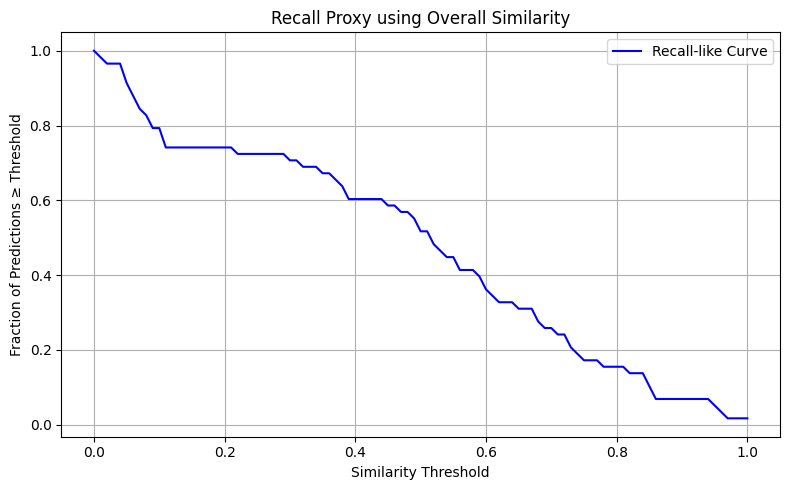

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Let's assume you already have this column:
similarity_scores = seq2seqParsing['Overall Similarity Seq2Seq']

# Sweep thresholds from 0.0 to 1.0
thresholds = np.arange(0.0, 1.01, 0.01)
recalls = []

for t in thresholds:
    # Count how many predictions are "accepted" at this threshold
    passed = (similarity_scores >= t).sum()
    recalls.append(passed / len(similarity_scores))  # fraction of all examples

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls, label='Recall-like Curve', color='blue')
plt.xlabel('Similarity Threshold')
plt.ylabel('Fraction of Predictions ≥ Threshold')
plt.title('Recall Proxy using Overall Similarity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


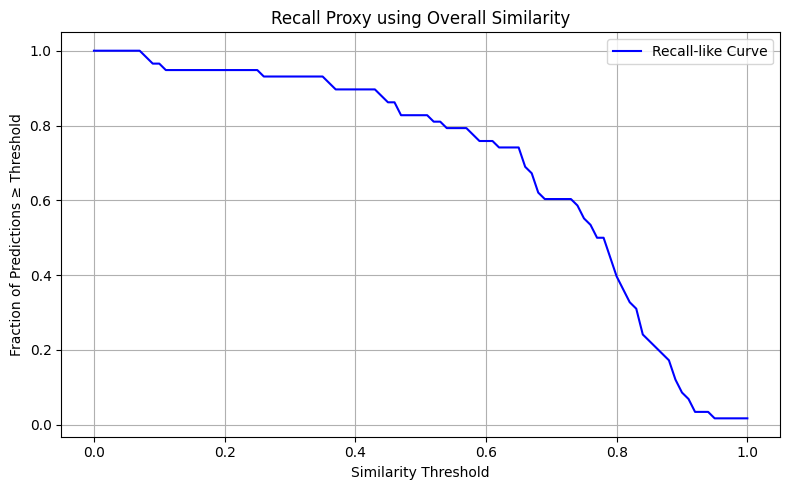

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Let's assume you already have this column:
similarity_scores = seq2seqParsing['Overall Similarity Rule Based']

# Sweep thresholds from 0.0 to 1.0
thresholds = np.arange(0.0, 1.01, 0.01)
recalls = []

for t in thresholds:
    # Count how many predictions are "accepted" at this threshold
    passed = (similarity_scores >= t).sum()
    recalls.append(passed / len(similarity_scores))  # fraction of all examples

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls, label='Recall-like Curve', color='blue')
plt.xlabel('Similarity Threshold')
plt.ylabel('Fraction of Predictions ≥ Threshold')
plt.title('Recall Proxy using Overall Similarity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
